In [35]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.optim as optim
import os
import time
import numpy as np
import pandas as pd
#!pip install gensim
import gensim

In [33]:
PATH_OUTPUT = "./"

In [183]:
admission = pd.read_csv("./mortality/train/ADMISSIONS.csv")
mortality = pd.read_csv("./mortality/train/MORTALITY.csv")

In [184]:
diags = admission[['SUBJECT_ID', 'DIAGNOSIS']]
for i in range(len(diags)):
    if isinstance(diags.DIAGNOSIS[i], str):
        diags.DIAGNOSIS[i] = diags.DIAGNOSIS[i].replace('\\', ' ').\
            replace('/', ' ').replace(',', ' ').\
            replace(';', ' ').replace('*', '') + ' '

diags = diags.groupby('SUBJECT_ID').agg('sum')
diags

<ipython-input-184-5a66503d78b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diags.DIAGNOSIS[i] = diags.DIAGNOSIS[i].replace('\\', ' ').\
/home/xyj/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,DIAGNOSIS
SUBJECT_ID,
17,PATIENT FORAMEN OVALE PATENT FORAMEN OVALE MI...
21,CONGESTIVE HEART FAILURE SEPSIS
23,CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS...
34,CHEST PAIN CATH BRADYCARDIA
36,CORONARY ARTERY DISEASE CORONARY ARTERY BYPASS...
...,...
99781,MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURI...
99822,SQUAMOUS CELL CANCER HYPONATREMIA DIARRHEA
99883,CARDIOMYOPATHY CARDIAC CATH CORONARY ARTERY DI...


In [185]:
train_data = pd.merge(mortality, diags, on='SUBJECT_ID')
train_data.DIAGNOSIS = train_data.DIAGNOSIS.apply(lambda x: x if isinstance(x, str) else ' ')

In [233]:
train_corpus = train_data.DIAGNOSIS.apply(lambda x: x.split(" "))
model = gensim.models.Word2Vec(sentences=train_corpus)
word_map = model.wv.key_to_index

In [234]:
diag_len = train_data.DIAGNOSIS.apply(lambda x: x.split(" ")).apply(len).max()
diag_len

183

In [235]:
train_X = (
    train_data
    .DIAGNOSIS
    .apply(lambda x: list(map(lambda word: word_map[word] if word in word_map else 1, x.split(" "))))
)
print(train_X[0])

[1, 24, 20, 166, 63, 64, 37, 106, 24, 20, 202, 25, 0]


In [236]:
train_X = (
    list(
        map(
            lambda x: pd.np.pad(x, (0, diag_len-len(x))), 
            train_X
        )
    )
)
train_X[0]

<ipython-input-236-127d08543fc2>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  lambda x: pd.np.pad(x, (0, diag_len-len(x))),


array([  1,  24,  20, 166,  63,  64,  37, 106,  24,  20, 202,  25,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [237]:
train_X = (
    list(
        map(
            lambda x: torch.LongTensor(x), 
            train_X
        )
    )
)
train_X[0]

tensor([  1,  24,  20, 166,  63,  64,  37, 106,  24,  20, 202,  25,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [270]:
train_X = torch.stack(train_X)
train_target = train_data.MORTALITY.values.reshape(-1,1)
train_target = torch.tensor(train_target).reshape(-1)
train_dataloader = TensorDataset(train_X, train_target)

In [271]:
train_target

tensor([1, 1, 0,  ..., 1, 1, 0])

In [239]:
word_vectors_for_training = pd.np.insert(
    model.wv.vectors,   
    0, 
    pd.np.random.uniform(model.wv.vectors.min(),model.wv.vectors.max(),300),
    axis=0
)

word_vectors_for_training = pd.np.insert(
    word_vectors_for_training,   
    0, 
    pd.np.zeros(300),
    axis=0
)
word_vectors_for_training = torch.FloatTensor(word_vectors_for_training)
word_vectors_for_training.shape

<ipython-input-239-8c442d60ac87>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  word_vectors_for_training = pd.np.insert(
<ipython-input-239-8c442d60ac87>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.random.uniform(model.wv.vectors.min(),model.wv.vectors.max(),300),


ValueError: could not broadcast input array from shape (1,300) into shape (1,100)

In [321]:
class PatientRep(nn.Module):
    def __init__(self, weight):
        super(PatientRep, self).__init__() 
        #self.embedding = nn.Embedding(5000, 300)
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.avgpool = nn.AvgPool1d(100)
        self.linear = nn.Linear(183, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.avgpool(self.embedding(x))
        x = self.relu(self.linear(torch.squeeze(x)))
        x = self.output(x)
        return torch.squeeze(x)

In [338]:
model = PatientRep(train_weight)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

device = torch.device("cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

In [339]:
for i in range(100):
    optimizer.zero_grad()
    output = model(train_X)
    loss = criterion(output, train_target.float())
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())


In [341]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curve')

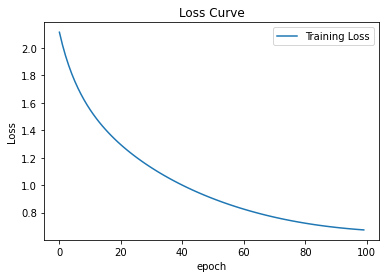

In [342]:
epoches = list(range(len(train_losses)))
plt.plot(epoches, train_losses, label = "Training Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Loss Curve")

In [ ]:
# load test data

In [343]:
test_admission = pd.read_csv("./mortality/validation/ADMISSIONS.csv")
test_mortality = pd.read_csv("./mortality/validation/MORTALITY.csv")

In [345]:
test_diags = test_admission[['SUBJECT_ID', 'DIAGNOSIS']]
for i in range(len(test_diags)):
    if isinstance(test_diags.DIAGNOSIS[i], str):
        test_diags.DIAGNOSIS[i] = test_diags.DIAGNOSIS[i].replace('\\', ' ').\
            replace('/', ' ').replace(',', ' ').\
            replace(';', ' ').replace('*', '') + ' '

test_diags = test_diags.groupby('SUBJECT_ID').agg('sum')
test_diags

<ipython-input-345-eb02aa5b2a88>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_diags.DIAGNOSIS[i] = test_diags.DIAGNOSIS[i].replace('\\', ' ').\
/home/xyj/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,DIAGNOSIS
SUBJECT_ID,
68,PNEUMONIA WEAKNESS
105,FEVER ORIGIN UNKNOWN DYSRHYTHMIA TELEMETRY FEVER
117,LIVER FAILURE S P TIPS ENCEPHALOPATHY LIVER FA...
157,SUBDURAL BLEED SEPSIS
209,UNSTABLE ANGINA NON-ST SEGMENT ELEVATION MYOCA...
...,...
99054,UPPER GI BLEED UPPER GI BLEED
99088,MALIGNANT NEOPLASM RIGHT HAND SDA LUNG ABSCES...
99185,CORONARY ARTERY DISEASE CHRONIC OBST PULM DISE...


In [346]:
test_data = pd.merge(test_mortality, test_diags, on='SUBJECT_ID')
test_data.DIAGNOSIS = test_data.DIAGNOSIS.apply(lambda x: x if isinstance(x, str) else ' ')

In [347]:
test_diag_len = test_data.DIAGNOSIS.apply(lambda x: x.split(" ")).apply(len).max()
test_diag_len

68

In [348]:
test_X = (
    test_data
    .DIAGNOSIS
    .apply(lambda x: list(map(lambda word: word_map[word] if word in word_map else 1, x.split(" "))))
)
print(test_X[0])

[5, 79, 109, 0]


In [351]:
test_X = (
    list(
        map(
            lambda x: pd.np.pad(x, (0, diag_len-len(x))), 
            test_X
        )
    )
)
train_X[0]

<ipython-input-351-f980d7d14079>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  lambda x: pd.np.pad(x, (0, diag_len-len(x))),


tensor([  1,  24,  20, 166,  63,  64,  37, 106,  24,  20, 202,  25,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [352]:
test_X = (
    list(
        map(
            lambda x: torch.LongTensor(x), 
            test_X
        )
    )
)
test_X[0]

tensor([  5,  79, 109,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [353]:
test_X = torch.stack(test_X)

In [354]:
model.eval()

In [357]:
res = model.avgpool(model.embedding(test_X))
res = model.linear(torch.squeeze(res))

In [363]:
res = res.detach().numpy()

In [364]:
res

array([[-0.01954903,  0.03564813,  0.07386118, ..., -0.03804045,
        -0.05819615,  0.06601918],
       [-0.01859373,  0.02492965,  0.10262744, ..., -0.0465885 ,
        -0.0669103 ,  0.07853486],
       [-0.02198775,  0.04155006,  0.0484906 , ..., -0.03352645,
        -0.05043018,  0.05113207],
       ...,
       [-0.02708451,  0.03771221,  0.06688596, ..., -0.0358182 ,
        -0.05692606,  0.05895178],
       [-0.02850868,  0.03859878,  0.07114066, ..., -0.03704749,
        -0.06112958,  0.06426977],
       [-0.0349398 ,  0.04757274,  0.06099521, ..., -0.03746616,
        -0.05434515,  0.05549812]], dtype=float32)

In [366]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [367]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(res)

In [368]:
kmeans = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=2, random_state=42)

In [369]:
kmeans.labels_

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [372]:
test_target = test_data.MORTALITY.values
test_target

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,

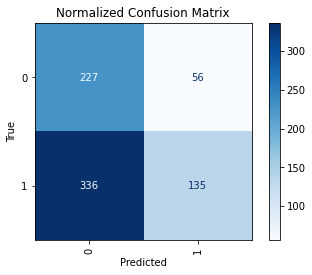

In [377]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_target, (kmeans.labels_-1)**2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp = disp.plot(xticks_rotation='vertical', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()